<a href="https://colab.research.google.com/github/npauuul/Red-Neuronal-Precios-Casas/blob/main/Construcci%C3%B3n_de_una_Red_Neuronal_para_Predecir_Precios_de_Viviendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación del entorno

In [ ]:
# Instalación de paquetes necesarios
pip install tensorflow keras matplotlib numpy pandas scikit-learn

# Código para el entrenamiento


=== Muestra de datos ===
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude     PRICE  
0    -122.23  452600.0  
1    -122.22  358500.0  
2    -122.24  352100.0  
3    -122.25  341300.0  
4    -122.25  342200.0  


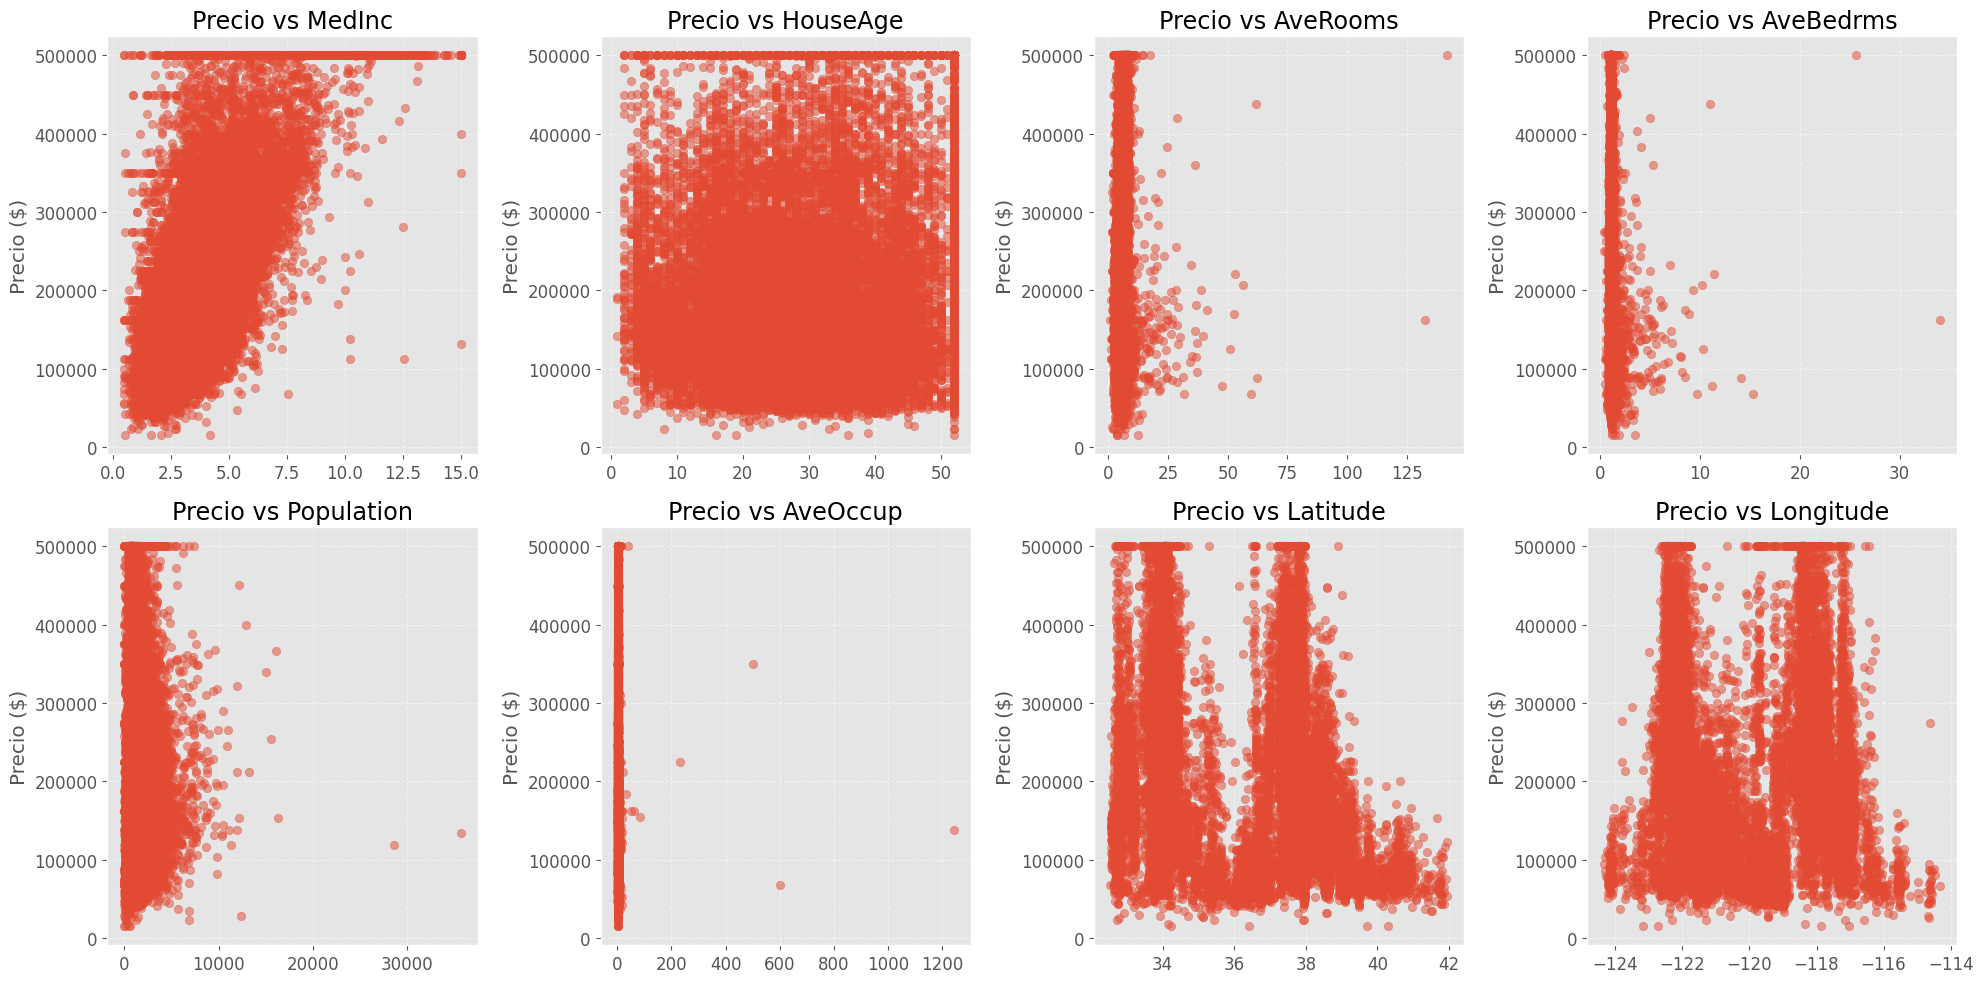


=== Regresión Lineal (AveRooms) ===
MSE: $12,923,314,440.81
R²: 1.38%


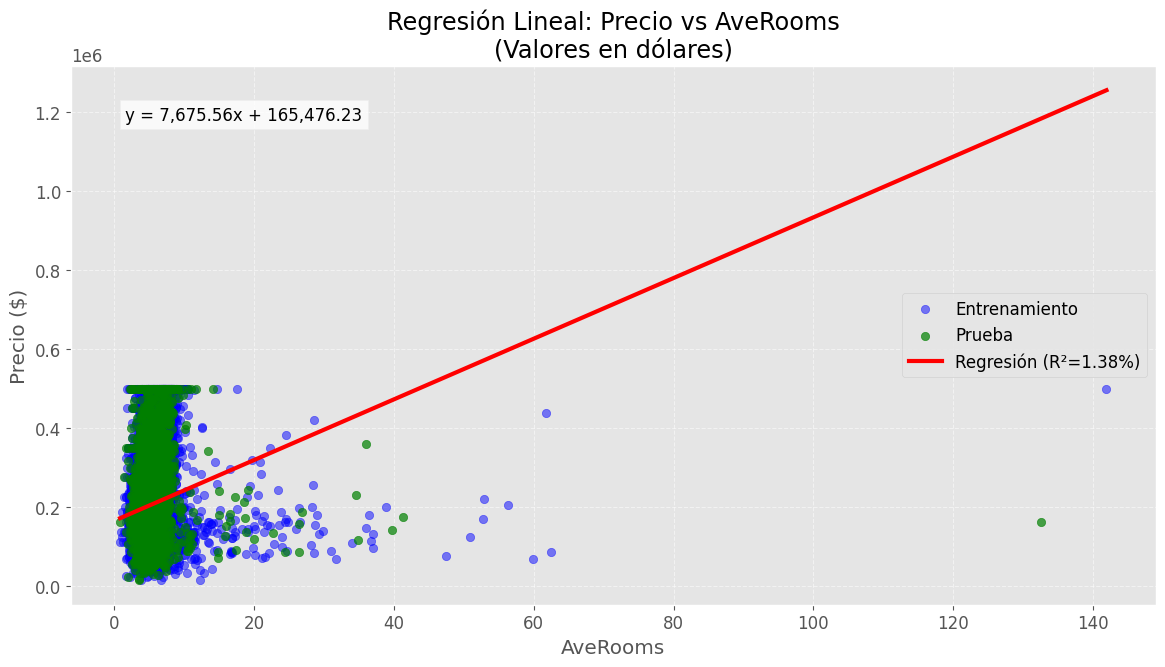

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Entrenando red neuronal...
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Red Neuronal ===
MSE: $4,346,070,731.06
R²: 66.83%


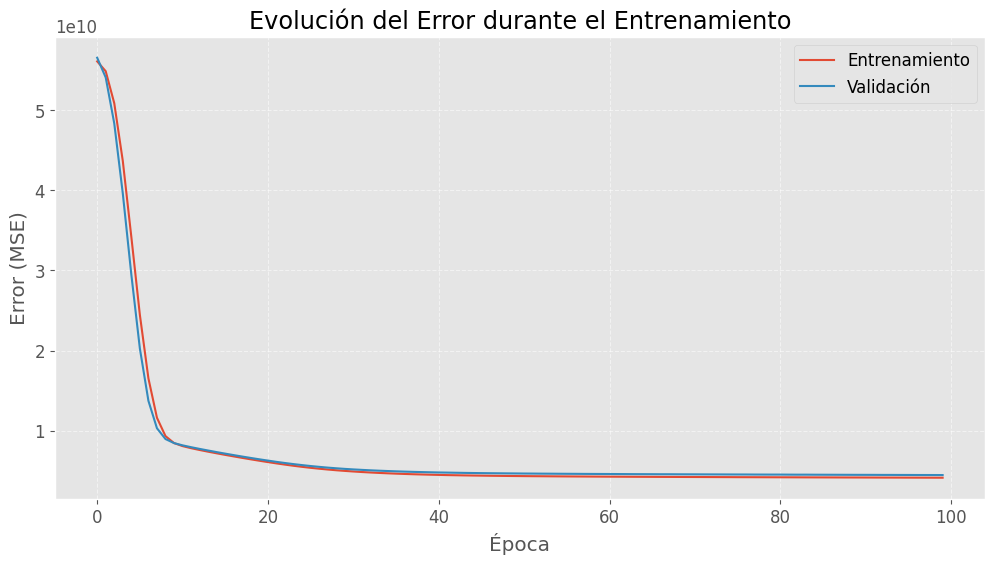

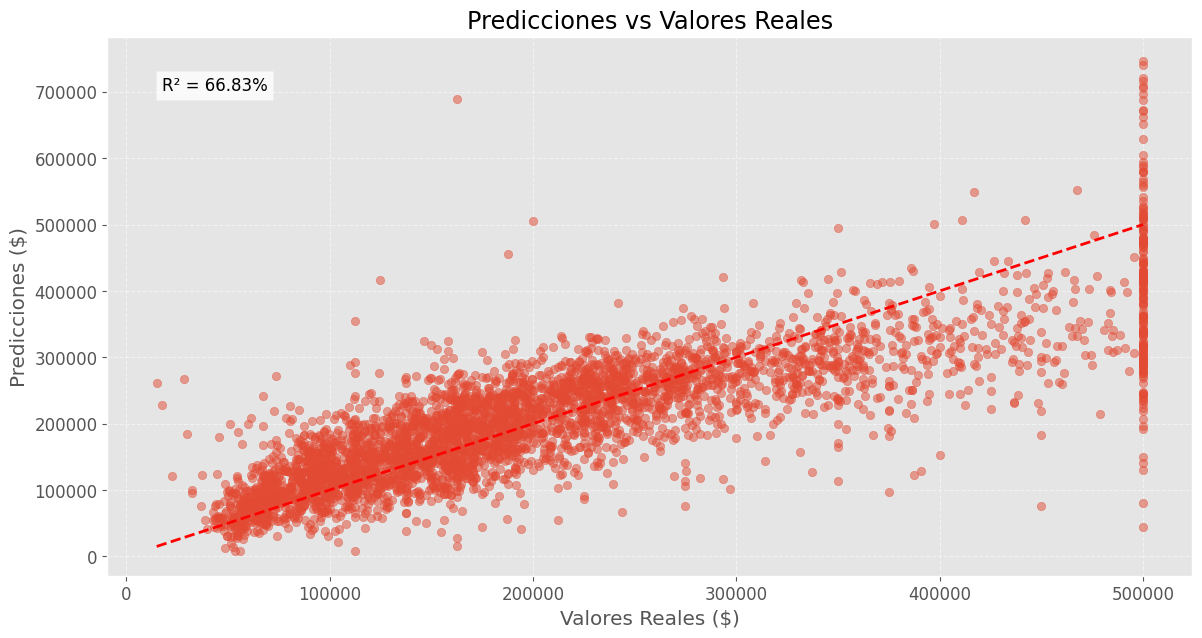

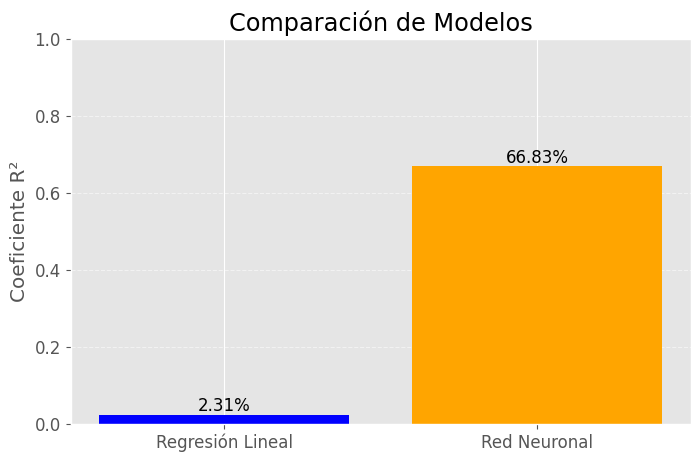

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuración de gráficos alternativa (sin dependencia de seaborn)
plt.style.use('ggplot')  # Usamos 'ggplot' que está disponible por defecto
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# 1. Carga y preparación de datos =============================================
def load_and_prepare_data():
    """Carga y prepara los datos de viviendas de California"""
    california = fetch_california_housing()
    data = pd.DataFrame(california.data, columns=california.feature_names)
    data['PRICE'] = california.target * 100000  # Convertir a dólares
    return data

data = load_and_prepare_data()
print("\n=== Muestra de datos ===")
print(data.head())

# 2. Visualización de datos ===================================================
def plot_feature_relationships(data):
    """Visualiza la relación entre características y precio"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for i, col in enumerate(data.columns[:-1]):
        axes[i].scatter(data[col], data['PRICE'], alpha=0.5)
        axes[i].set_title(f'Precio vs {col}')
        axes[i].set_ylabel('Precio ($)')
        axes[i].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_relationships(data)

# 3. Regresión Lineal Simple ==================================================
def linear_regression_analysis(data, feature='AveRooms'):
    """Realiza y visualiza regresión lineal simple"""
    X = data[[feature]].values
    y = data['PRICE'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== Regresión Lineal ({feature}) ===")
    print(f"MSE: ${mse:,.2f}")
    print(f"R²: {r2:.2%}")

    # Gráfico de regresión
    plt.figure(figsize=(14, 7))
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Entrenamiento')
    plt.scatter(X_test, y_test, color='green', alpha=0.7, label='Prueba')

    x_range = np.linspace(X.min(), X.max(), 100)
    plt.plot(x_range, model.predict(x_range.reshape(-1, 1)),
             color='red', linewidth=3,
             label=f'Regresión (R²={r2:.2%})')

    plt.title(f'Regresión Lineal: Precio vs {feature}\n(Valores en dólares)')
    plt.xlabel(f'{feature}')
    plt.ylabel('Precio ($)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Añadir ecuación
    eq = f'y = {model.coef_[0]:,.2f}x + {model.intercept_:,.2f}'
    plt.text(0.05, 0.9, eq, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.savefig('linear_regression.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model

lr_model = linear_regression_analysis(data)

# 4. Red Neuronal =============================================================
def build_and_train_nn(data):
    """Construye y entrena una red neuronal"""
    X = data.drop('PRICE', axis=1).values
    y = data['PRICE'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42)

    # Modelo más simple para mayor estabilidad
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print("\nEntrenando red neuronal...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=0
    )

    # Evaluación
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n=== Red Neuronal ===")
    print(f"MSE: ${mse:,.2f}")
    print(f"R²: {r2:.2%}")

    # Gráfico de evolución
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Evolución del Error durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Error (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig('nn_training.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Gráfico de predicciones
    plt.figure(figsize=(14, 7))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             '--r', linewidth=2)
    plt.title('Predicciones vs Valores Reales')
    plt.xlabel('Valores Reales ($)')
    plt.ylabel('Predicciones ($)')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Añadir métricas
    plt.text(0.05, 0.9, f'R² = {r2:.2%}', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.savefig('nn_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model, r2

nn_model, nn_r2 = build_and_train_nn(data)

# 5. Comparación Final ========================================================
def compare_models(lr_r2, nn_r2):
    """Compara visualmente el rendimiento de los modelos"""
    comparison = pd.DataFrame({
        'Modelo': ['Regresión Lineal', 'Red Neuronal'],
        'R²': [lr_r2, nn_r2]
    })

    plt.figure(figsize=(8, 5))
    bars = plt.bar(comparison['Modelo'], comparison['R²'], color=['blue', 'orange'])

    plt.title('Comparación de Modelos')
    plt.ylabel('Coeficiente R²')
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2%}',
                 ha='center', va='bottom')

    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Obtener R² de regresión lineal
X = data[['AveRooms']].values
y = data['PRICE'].values
lr_r2 = r2_score(y, LinearRegression().fit(X, y).predict(X))

compare_models(lr_r2, nn_r2)